In [1]:
import gymnasium as gym
import numpy as np
import d3rlpy
import pickle

import matplotlib.pyplot as plt
from env.atari.represented_atari_game import GymCompatWrapper2

hyperparams = {
        "env": "CartPole-v0", #"CartPole-v0", # "Acrobot-v0", "MountainCar-v0", "FrozenLake-v1", "CliffWalking-v0", "Taxi-v3", "RepresentedPong-v0"
        "seed": 42069,
        "n_episodes": 100,#5000,
        "max_episode_len": 200, # Around 10h per 100k steps in Leviathan server
        "eps": 0.1,  # epsilon for exploration
        "n_exp": 5,
        "n_pretrain_eps": 30,
        "n_online_eps": 170, #10-290 for mountainCar, 30-170 for CartPole
        "gpu": True, # True if use GPU to train with d3rlpy
        "buffer_size": 100000, #Test with 100k, 200k, 500k. 1M might be too much
        "data_path": None,#'data/CartPole_Qwen2.5-7B-Instruct_Neps_10_20250406040150.pkl',
        "model_path": None,#'d3rlpy_loss/DoubleDQN_online_20250331153346/model_600000.d3',
        "batch_size":256, #Test smaller batch size: 32, 64. May be noisier
        "learning_rate":5e-5,
        "gamma":0.99,
        "target_update_interval":1000 #Test with 1k, 2k, 5k
    }

if "Represented" in hyperparams["env"]:
    env = GymCompatWrapper2(gym.make(hyperparams["env"]))
    eval_env = GymCompatWrapper2(gym.make(hyperparams["env"]))
else:
    env = gym.make(hyperparams["env"])
    eval_env = gym.make(hyperparams["env"])

# fix seed
d3rlpy.seed(hyperparams["seed"])
d3rlpy.envs.seed_env(env, hyperparams["seed"])
d3rlpy.envs.seed_env(eval_env, hyperparams["seed"])

2025-04-09 22:33.10 [info     ] Register Shimmy environments. 


/opt/miniconda3/envs/llamagym/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/miniconda3/envs/llamagym/lib/python3.9/site-packages/gymnasium/envs/registration.py:513: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


### Static/pretrain data

In [ ]:
# with open(f"data/{hyperparams['env'].split('-')[0]}_Qwen2.5-7B-Instruct_Neps_{hyperparams['n_pretrain_eps']}_20250408032240_withEps.pkl", 'rb') as file:
#     Qwen_7B_dataset = pickle.load(file)

# with open(f"data/{hyperparams['env'].split('-')[0]}_Qwen2.5-32B-Instruct_Neps_{hyperparams['n_pretrain_eps']}_20250408120007_withEps.pkl", 'rb') as file:
#     Qwen_32B_dataset = pickle.load(file)

# with open(f"data/{hyperparams['env'].split('-')[0]}_Qwen2.5-7B-Instruct_Neps_{hyperparams['n_pretrain_eps']}_20250407113942.pkl", 'rb') as file:
#     Qwen_7B_dataset = pickle.load(file)

# with open(f"data/{hyperparams['env'].split('-')[0]}_Qwen2.5-32B-Instruct_Neps_{hyperparams['n_pretrain_eps']}_20250407125034.pkl", 'rb') as file:
#     Qwen_32B_dataset = pickle.load(file)

with open(f"data/{hyperparams['env'].split('-')[0]}_Qwen2.5-7B-Instruct_Neps_{hyperparams['n_pretrain_eps']}_20250409023954.pkl", 'rb') as file:
    Qwen_7B_dataset = pickle.load(file)

with open(f"data/{hyperparams['env'].split('-')[0]}_Qwen2.5-32B-Instruct_Neps_{hyperparams['n_pretrain_eps']}_20250409124533.pkl", 'rb') as file:
    Qwen_32B_dataset = pickle.load(file)

Qwen_32B_rewards = []
for i in range(hyperparams["n_pretrain_eps"]):
    Qwen_32B_rewards.append(Qwen_32B_dataset.episodes[i].compute_return())
Qwen_7B_rewards = []
for i in range(hyperparams["n_pretrain_eps"]):
    Qwen_7B_rewards.append(Qwen_7B_dataset.episodes[i].compute_return())

Qwen_7B = Qwen_7B_rewards + hyperparams["n_online_eps"] * [np.mean(Qwen_7B_rewards)]
Qwen_32B = Qwen_32B_rewards + hyperparams["n_online_eps"] * [np.mean(Qwen_32B_rewards)]

# Qwen_32B = np.ones(hyperparams["n_pretrain_eps"] + hyperparams["n_online_eps"]) * np.mean(Qwen_32B_rewards)
# Qwen_7B = np.ones(hyperparams["n_pretrain_eps"] + hyperparams["n_online_eps"]) * np.mean(Qwen_7B_rewards)
print("Qwen_32B: ", np.mean(Qwen_7B_rewards))
print("Qwen_7B: ", np.mean(Qwen_32B_rewards))

Qwen_32B:  34.266666666666666
Qwen_7B:  45.6


### Generate and evaluate random baseline

In [9]:
# Evaluate the random policy manually
random_rewards = []
for _ in range(hyperparams["n_pretrain_eps"]):
	obs, _ = env.reset()
	done = False
	total_reward = 0
	count = 0
	while not done:
		action = env.action_space.sample()
		obs, reward, done, _, _ = env.step(action)
		total_reward += reward
		count += 1
		if count >= hyperparams["max_episode_len"]:
			break
	random_rewards.append(total_reward)

mean_random = np.ones(hyperparams["n_pretrain_eps"] + hyperparams["n_online_eps"]) * np.mean(random_rewards)
# Print the average reward of the random policy
print(f"Average reward for random policy: {mean_random[0]}")

Average reward for random policy: 20.0


### Fine-tune and Online data

In [5]:
with open(f"data/cache_{hyperparams['env'].split('-')[0]}.pkl", 'rb') as file:
# with open(f"data/cache_{hyperparams['env'].split('-')[0]}_withEps.pkl", 'rb') as file:
    cache = pickle.load(file)

online_returns = np.zeros((hyperparams["n_exp"], hyperparams["n_pretrain_eps"] + hyperparams["n_online_eps"]))
finetune_7b_returns = np.zeros((hyperparams["n_exp"], hyperparams["n_pretrain_eps"] + hyperparams["n_online_eps"]))
finetune_32b_returns = np.zeros((hyperparams["n_exp"], hyperparams["n_pretrain_eps"] + hyperparams["n_online_eps"]))
pretrain_7b_1000_returns = np.zeros((hyperparams["n_exp"], hyperparams["n_pretrain_eps"] + hyperparams["n_online_eps"]))
pretrain_32b_1000_returns = np.zeros((hyperparams["n_exp"], hyperparams["n_pretrain_eps"] + hyperparams["n_online_eps"]))
pretrain_7b_3000_returns = np.zeros((hyperparams["n_exp"], hyperparams["n_pretrain_eps"] + hyperparams["n_online_eps"]))
pretrain_32b_3000_returns = np.zeros((hyperparams["n_exp"], hyperparams["n_pretrain_eps"] + hyperparams["n_online_eps"]))

for i in range(hyperparams["n_exp"]):
    online_returns[i] = cache[f"online_{i}"]
    for j in range(hyperparams["n_online_eps"]):
        finetune_7b_returns[i][hyperparams["n_pretrain_eps"]+j] = cache[f"finetune_7b_{i}"][j]
        finetune_32b_returns[i][hyperparams["n_pretrain_eps"]+j] = cache[f"finetune_32b_{i}"][j]
        pretrain_7b_1000_returns[i][hyperparams["n_pretrain_eps"]+j] = cache[f"pretrain_7b_1000_{i}"][j]
        pretrain_32b_1000_returns[i][hyperparams["n_pretrain_eps"]+j] = cache[f"pretrain_32b_1000_{i}"][j]
        pretrain_7b_3000_returns[i][hyperparams["n_pretrain_eps"]+j] = cache[f"pretrain_7b_3000_{i}"][j]
        pretrain_32b_3000_returns[i][hyperparams["n_pretrain_eps"]+j] = cache[f"pretrain_32b_3000_{i}"][j]

# Plot

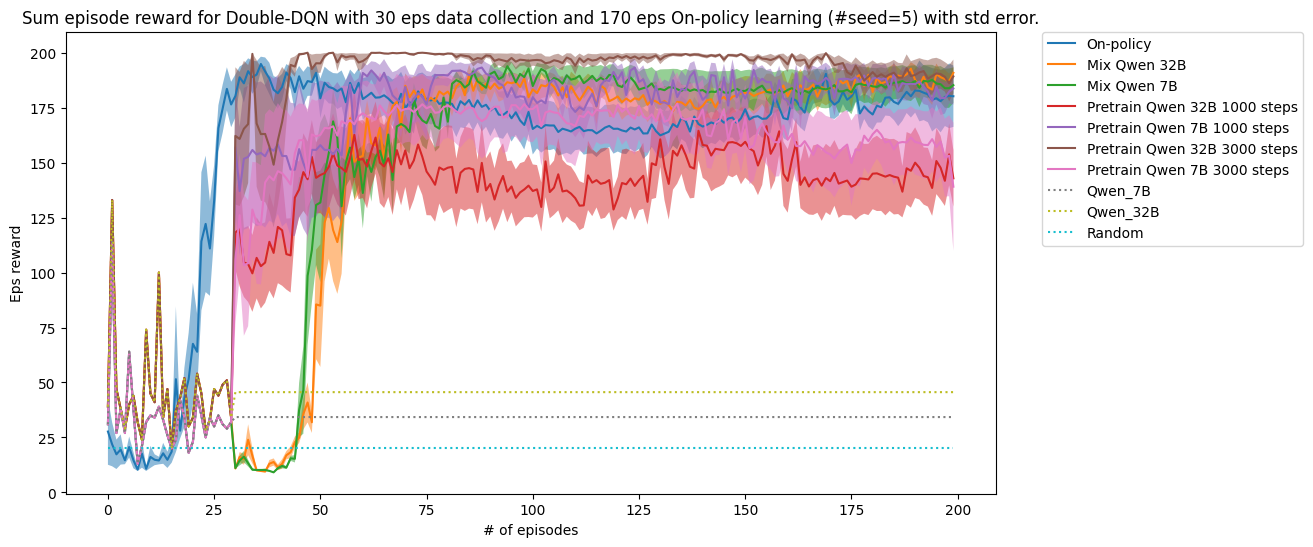

In [22]:
x = range(hyperparams["n_pretrain_eps"] + hyperparams["n_online_eps"])

mean_finetune_32b = np.mean(finetune_32b_returns, axis = 0)
std_finetune_32b = np.std(finetune_32b_returns, axis = 0)
mean_finetune_7b = np.mean(finetune_7b_returns, axis = 0)
std_finetune_7b = np.std(finetune_7b_returns, axis = 0)
mean_onl = np.mean(online_returns, axis = 0)
std_onl = np.std(online_returns, axis = 0)
mean_pretrain_32b_1000 = np.mean(pretrain_32b_1000_returns, axis = 0)
std_pretrain_32b_1000 = np.std(pretrain_32b_1000_returns, axis = 0)
mean_pretrain_7b_1000 = np.mean(pretrain_7b_1000_returns, axis = 0)
std_pretrain_7b_1000 = np.std(pretrain_7b_1000_returns, axis = 0)
mean_pretrain_32b_3000 = np.mean(pretrain_32b_3000_returns, axis = 0)
std_pretrain_32b_3000 = np.std(pretrain_32b_3000_returns, axis = 0)
mean_pretrain_7b_3000 = np.mean(pretrain_7b_3000_returns, axis = 0)
std_pretrain_7b_3000 = np.std(pretrain_7b_3000_returns, axis = 0)

mean_finetune_7b[:hyperparams["n_pretrain_eps"]] = Qwen_7B[:hyperparams["n_pretrain_eps"]]
mean_finetune_32b[:hyperparams["n_pretrain_eps"]] = Qwen_32B[:hyperparams["n_pretrain_eps"]]
mean_pretrain_32b_1000[:hyperparams["n_pretrain_eps"]] = Qwen_32B[:hyperparams["n_pretrain_eps"]]
mean_pretrain_7b_1000[:hyperparams["n_pretrain_eps"]] = Qwen_7B[:hyperparams["n_pretrain_eps"]]
mean_pretrain_32b_3000[:hyperparams["n_pretrain_eps"]] = Qwen_32B[:hyperparams["n_pretrain_eps"]]
mean_pretrain_7b_3000[:hyperparams["n_pretrain_eps"]] = Qwen_7B[:hyperparams["n_pretrain_eps"]]

plt.figure(figsize=(12, 6))
plt.plot(mean_onl, label='On-policy')
plt.fill_between(x, mean_onl-std_onl/np.sqrt(hyperparams["n_exp"]), mean_onl+std_onl/np.sqrt(hyperparams["n_exp"]), alpha=0.5)
plt.plot(mean_finetune_32b, label='Mix Qwen 32B')
plt.fill_between(x, mean_finetune_32b-std_finetune_32b/np.sqrt(hyperparams["n_exp"]), mean_finetune_32b+std_finetune_32b/np.sqrt(hyperparams["n_exp"]), alpha=0.5)
plt.plot(mean_finetune_7b, label='Mix Qwen 7B')
plt.fill_between(x, mean_finetune_7b-std_finetune_7b/np.sqrt(hyperparams["n_exp"]), mean_finetune_7b+std_finetune_7b/np.sqrt(hyperparams["n_exp"]), alpha=0.5)
plt.plot(mean_pretrain_32b_1000, label='Pretrain Qwen 32B 1000 steps')
plt.fill_between(x, mean_pretrain_32b_1000-std_pretrain_32b_1000/np.sqrt(hyperparams["n_exp"]), mean_pretrain_32b_1000+std_pretrain_32b_1000/np.sqrt(hyperparams["n_exp"]), alpha=0.5)
plt.plot(mean_pretrain_7b_1000, label='Pretrain Qwen 7B 1000 steps')
plt.fill_between(x, mean_pretrain_7b_1000-std_pretrain_7b_1000/np.sqrt(hyperparams["n_exp"]), mean_pretrain_7b_1000 +std_pretrain_7b_1000/np.sqrt(hyperparams["n_exp"]), alpha=0.5)
plt.plot(mean_pretrain_32b_3000, label='Pretrain Qwen 32B 3000 steps')
plt.fill_between(x, mean_pretrain_32b_3000-std_pretrain_32b_3000/np.sqrt(hyperparams["n_exp"]), mean_pretrain_32b_3000+std_pretrain_32b_3000/np.sqrt(hyperparams["n_exp"]), alpha=0.5)
plt.plot(mean_pretrain_7b_3000, label='Pretrain Qwen 7B 3000 steps')
plt.fill_between(x, mean_pretrain_7b_3000-std_pretrain_7b_3000/np.sqrt(hyperparams["n_exp"]), mean_pretrain_7b_3000 +std_pretrain_7b_3000/np.sqrt(hyperparams["n_exp"]), alpha=0.5)

plt.plot(Qwen_7B, label='Qwen_7B', linestyle=':')
plt.plot(Qwen_32B, label='Qwen_32B', linestyle=':')
plt.plot(mean_random, label='Random', linestyle=':')

# Customize the plot
plt.title(f'Sum episode reward for Double-DQN with {hyperparams["n_pretrain_eps"]} eps data collection and {hyperparams["n_online_eps"]} eps On-policy learning (#seed={hyperparams["n_exp"]}) with std error.')
plt.xlabel('# of episodes')
plt.ylabel('Eps reward')
# plt.legend()
# plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
# plt.xticks(np.arange(0, 101, 10))
# Show the plot
plt.show()

In [23]:
# # Create the plot
# plt.figure(figsize=(10, 6))

# plt.plot(mean_onl, label='On-policy')
# plt.fill_between(x, mean_onl-std_onl, mean_onl+std_onl, alpha=0.5)
# plt.plot(mean_finetune_32b, label='Mix Qwen 32B')
# plt.fill_between(x, mean_finetune_32b-std_finetune_32b, mean_finetune_32b+std_finetune_32b, alpha=0.5)
# plt.plot(mean_finetune_7b, label='Mix Qwen 7B')
# plt.fill_between(x, mean_finetune_7b-std_finetune_7b, mean_finetune_7b+std_finetune_7b, alpha=0.5)
# plt.plot(mean_pretrain_32b_1000, label='Pretrain Qwen 32B 1000 steps')
# plt.fill_between(x, mean_pretrain_32b_1000-std_pretrain_32b_1000, mean_pretrain_32b_1000+std_pretrain_32b_1000, alpha=0.5)
# plt.plot(mean_pretrain_7b_1000, label='Pretrain Qwen 7B 1000 steps')
# plt.fill_between(x, mean_pretrain_7b_1000-std_pretrain_7b_1000, mean_pretrain_7b_1000 +std_pretrain_7b_1000, alpha=0.5)
# plt.plot(mean_pretrain_32b_3000, label='Pretrain Qwen 32B 3000 steps')
# plt.fill_between(x, mean_pretrain_32b_3000-std_pretrain_32b_3000, mean_pretrain_32b_3000+std_pretrain_32b_3000, alpha=0.5)
# plt.plot(mean_pretrain_7b_3000, label='Pretrain Qwen 7B 3000 steps')
# plt.fill_between(x, mean_pretrain_7b_3000-std_pretrain_7b_3000, mean_pretrain_7b_3000 +std_pretrain_7b_3000, alpha=0.5)

# plt.plot(Qwen_7B, label='Qwen_7B', linestyle=':')
# plt.plot(Qwen_32B, label='Qwen_32B', linestyle=':')
# plt.plot(mean_random, label='Random', linestyle=':')

# # Customize the plot
# plt.title(f'Sum episode reward for Double-DQN with {hyperparams["n_pretrain_eps"]} eps data collection and {hyperparams["n_online_eps"]} eps On-policy learning (#seed={hyperparams["n_exp"]})')
# plt.xlabel('# of episodes')
# plt.ylabel('Eps reward')
# # plt.legend()
# # plt.grid(True)
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
# # plt.xticks(np.arange(0, 101, 10))

# # Show the plot
# plt.show()

In [24]:
# def moving_average(data, window_size):
#     """Compute moving average using convolution."""
#     window = np.ones(window_size) / window_size
#     # return np.convolve(data, window, mode='valid')
#     half_window = window_size // 2
#     new_data = np.pad(data, (half_window, half_window), mode='reflect')  # Pad data to handle edges
#     return np.convolve(new_data, window, mode='valid')

# # Define the window size for smoothing
# window_size = 5  # Adjust this value as needed

# # Smooth the data
# smoothed_mean_onl = moving_average(mean_onl, window_size)
# smoothed_mean_finetune_32b = moving_average(mean_finetune_32b, window_size)
# smoothed_mean_finetune_7b = moving_average(mean_finetune_7b, window_size)
# smoothed_mean_pretrain_32b_1000 = moving_average(mean_pretrain_32b_1000, window_size)
# smoothed_mean_pretrain_7b_1000 = moving_average(mean_pretrain_7b_1000, window_size)
# smoothed_mean_pretrain_32b_3000 = moving_average(mean_pretrain_32b_3000, window_size)
# smoothed_mean_pretrain_7b_3000 = moving_average(mean_pretrain_7b_3000, window_size)

# # Adjust the x-axis range for the smoothed data
# x_smooth = range(len(smoothed_mean_onl))

# # Plot the smoothed results
# plt.figure(figsize=(10, 6))

# plt.plot(x_smooth, smoothed_mean_onl, label='Smoothed On-policy')
# plt.fill_between(x, smoothed_mean_onl-std_onl, smoothed_mean_onl+std_onl, alpha=0.5)
# plt.plot(x_smooth, smoothed_mean_finetune_32b, label='Smoothed Mix Qwen 32B')
# plt.fill_between(x, smoothed_mean_finetune_32b-std_finetune_32b, smoothed_mean_finetune_32b+std_finetune_32b, alpha=0.5)
# plt.plot(x_smooth, smoothed_mean_finetune_7b, label='Smoothed Mix Qwen 7B')
# plt.fill_between(x, smoothed_mean_finetune_7b-std_finetune_7b, smoothed_mean_finetune_7b+std_finetune_7b, alpha=0.5)
# plt.plot(smoothed_mean_pretrain_32b_1000, label='Smoothed Pretrain Qwen 32B 1000 steps')
# plt.fill_between(x, smoothed_mean_pretrain_32b_1000-std_pretrain_32b_1000, smoothed_mean_pretrain_32b_1000+std_pretrain_32b_1000, alpha=0.5)
# plt.plot(smoothed_mean_pretrain_7b_1000, label='Smoothed Pretrain Qwen 7B 1000 steps')
# plt.fill_between(x, smoothed_mean_pretrain_7b_1000-std_pretrain_7b_1000, smoothed_mean_pretrain_7b_1000 +std_pretrain_7b_1000, alpha=0.5)
# plt.plot(smoothed_mean_pretrain_32b_3000, label='Smoothed Pretrain Qwen 32B 3000 steps')
# plt.fill_between(x, smoothed_mean_pretrain_32b_3000-std_pretrain_32b_3000, smoothed_mean_pretrain_32b_3000+std_pretrain_32b_3000, alpha=0.5)
# plt.plot(smoothed_mean_pretrain_7b_3000, label='Smoothed Pretrain Qwen 7B 3000 steps')
# plt.fill_between(x, smoothed_mean_pretrain_7b_3000-std_pretrain_7b_3000, smoothed_mean_pretrain_7b_3000 +std_pretrain_7b_3000, alpha=0.5)

# plt.plot(Qwen_7B, label='Qwen_7B', linestyle=':')
# plt.plot(Qwen_32B, label='Qwen_32B', linestyle=':')
# plt.plot(mean_random, label='Random', linestyle=':')

# # Customize the plot
# plt.title(f'Smoothed sum episode reward for Double-DQN with {hyperparams["n_pretrain_eps"]} eps data collection and {hyperparams["n_online_eps"]} eps On-policy learning (#seed={hyperparams["n_exp"]})')
# plt.xlabel('# of episodes')
# plt.ylabel('Eps reward')
# # plt.grid(True)
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
# # plt.xticks(np.arange(0, 101, 10))
# # plt.legend()
# # plt.grid(True)

# # Show the plot
# plt.show()
